In [ ]:
!pip install seqeval

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, Features, Value, ClassLabel
import numpy as np
from seqeval.metrics import classification_report
from datasets import Dataset

In [11]:
bio_tags = [
 'O', 
 'B-DISEASE', 'I-DISEASE',
 'B-CHEMICAL', 'I-CHEMICAL'
]

In [6]:
import xml.etree.ElementTree as ET
import re

def parse_pubtator(xml_file, output_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    with open(output_file, "w", encoding="utf-8") as outf:
        for doc in root.findall(".//document"):
            for passage in doc.findall("passage"):
                text = passage.findtext("text")
                if not text:
                    continue

                base_offset = int(passage.findtext("offset"))
                span_map = {}  # char index -> (entity_type, B/I)

                for ann in passage.findall("annotation"):
                    ent_type = ann.find("infon[@key='type']").text.upper()
                    loc = ann.find("location")
                    start = int(loc.get("offset")) - base_offset
                    length = int(loc.get("length"))
                    end = start + length

                    start = max(0, start)
                    end = min(len(text), end)

                    if start < len(text):
                        span_map[start] = (ent_type, "B")
                        for i in range(start + 1, end):
                            if i < len(text):
                                span_map[i] = (ent_type, "I")

                for m in re.finditer(r"\S+", text):
                    token = m.group(0)
                    s = m.start()

                    if s in span_map:
                        ent_type, bio = span_map[s]
                        label = f"{bio}-{ent_type}"
                    else:
                        label = "O"

                    outf.write(f"{token}\t{label}\n")

                outf.write("\n")

In [7]:
parse_pubtator('/kaggle/input/bc5dr-full/CDR_TrainingSet.BioC.xml', 'train_output.conll')
parse_pubtator('/kaggle/input/bc5dr-full/CDR_DevelopmentSet.BioC.xml', 'val_output.conll')
parse_pubtator('/kaggle/input/bc5dr-full/CDR_TestSet.BioC.xml', 'test_output.conll')

In [8]:
def read_conll_file(file_path):
    sentences, labels = [], []
    current_sentence, current_labels = [], []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                word, label = line.split('\t')
                current_sentence.append(word)
                current_labels.append(label)
            else:
                if current_sentence:
                    sentences.append(current_sentence)
                    labels.append(current_labels)
                    current_sentence, current_labels = [], []
    
    if current_sentence:  # Don't forget the last sentence
        sentences.append(current_sentence)
        labels.append(current_labels)
    
    return sentences, labels

In [33]:
from sklearn.model_selection import train_test_split

train_sentences, train_labels = read_conll_file('train_output.conll')
val_sentences, val_labels = read_conll_file('val_output.conll')
test_sentences, test_labels = read_conll_file('test_output.conll')

train_sentences += val_sentences
train_labels += val_labels

val_sentences, test_sentences, val_labels, test_labels = train_test_split(
    test_sentences, test_labels, test_size=0.5, random_state=42
)

print(f"#train: {len(train_sentences)}, #val: {len(val_sentences)}, #test: {len(test_sentences)}")

#train: 2000, #val: 500, #test: 500


In [34]:
def convert_to_dataset(sentences, labels, bio_tags):
    label_map = {tag: i for i, tag in enumerate(bio_tags)}
    
    # Convert string labels to IDs
    label_ids = [[label_map[label] for label in sentence_labels] for sentence_labels in labels]
    
    return Dataset.from_dict({
        "tokens": sentences,
        "ner_tags": label_ids
    }, features=Features({
        "tokens": [Value("string")],
        "ner_tags": [ClassLabel(names=bio_tags)]
    }))

train_dataset = convert_to_dataset(train_sentences, train_labels, bio_tags)
val_dataset = convert_to_dataset(val_sentences, val_labels, bio_tags)
test_dataset = convert_to_dataset(test_sentences, test_labels, bio_tags)

In [73]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
# tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

In [74]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            # Special tokens have word_id set to None
            if word_idx is None:
                label_ids.append(-100)  # -100 will be ignored in loss calculation
            # For the first token of a word
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For subsequent subword tokens
            else:
                # If it's a B- tag, convert to I- for continuation
                if bio_tags[label[word_idx]].startswith("B-"):
                    i_tag = "I-" + bio_tags[label[word_idx]][2:]
                    label_ids.append(bio_tags.index(i_tag))
                else:
                    label_ids.append(label[word_idx])
            previous_word_idx = word_idx
            
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [75]:
tokenized_train = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_val = val_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test = test_dataset.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [76]:
model = AutoModelForTokenClassification.from_pretrained(
    "dmis-lab/biobert-v1.1",
    num_labels=len(bio_tags)
)

# model = AutoModelForTokenClassification.from_pretrained(
#     "google-bert/bert-base-cased",
#     num_labels=len(bio_tags)
# )

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
training_args = TrainingArguments(
    output_dir="./biobert-ner-custom",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    num_train_epochs=10,
    report_to=[]
)

In [78]:
def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = np.argmax(predictions, axis=2)
    
    # Remove ignored index (-100)
    true_predictions = [
        [bio_tags[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [bio_tags[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = classification_report(true_labels, true_predictions, output_dict=True)
    
    # Compute accuracy manually
    total = sum(len(seq) for seq in true_labels)
    correct = sum(
        p == l
        for preds, labels in zip(true_predictions, true_labels)
        for p, l in zip(preds, labels)
    )
    accuracy = correct / total if total > 0 else 0.0

    return {
        "precision": results["micro avg"]["precision"],
        "recall": results["micro avg"]["recall"],
        "f1": results["micro avg"]["f1-score"],
        "accuracy": accuracy,
    }

In [79]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [80]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.306600,0.154525,0.770359,0.851536,0.808916,0.952396
2,0.089100,0.147073,0.783263,0.866468,0.822767,0.952023
3,0.050300,0.150403,0.833196,0.863055,0.847863,0.957295
4,0.029400,0.176096,0.813281,0.888225,0.849103,0.956976
5,0.017700,0.195017,0.822880,0.889932,0.855093,0.959744
6,0.011400,0.201948,0.838319,0.884812,0.860938,0.959132
7,0.007900,0.216530,0.833667,0.887372,0.859682,0.958653
8,0.005400,0.232878,0.833868,0.886519,0.859388,0.958786
9,0.004700,0.237191,0.837751,0.889932,0.863053,0.959478
10,0.004000,0.235054,0.840340,0.886945,0.863014,0.959878


Checkpoint destination directory ./biobert-ner-custom/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./biobert-ner-custom/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1250, training_loss=0.05264712736606598, metrics={'train_runtime': 284.8519, 'train_samples_per_second': 70.212, 'train_steps_per_second': 4.388, 'total_flos': 1306519219200000.0, 'train_loss': 0.05264712736606598, 'epoch': 10.0})

In [81]:
test_results = trainer.evaluate(tokenized_test)
print(f"Test results: {test_results}")

Test results: {'eval_loss': 0.16490042209625244, 'eval_precision': 0.854251012145749, 'eval_recall': 0.9098749460974558, 'eval_f1': 0.8811860513677177, 'eval_accuracy': 0.9694419128290356, 'eval_runtime': 2.7504, 'eval_samples_per_second': 181.791, 'eval_steps_per_second': 22.906, 'epoch': 10.0}


In [82]:
predictions, labels, _ = trainer.predict(tokenized_test)
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [bio_tags[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [bio_tags[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

# Print detailed classification report
print(classification_report(true_labels, true_predictions))

total = sum(len(seq) for seq in true_labels)
correct = sum(
    p == l
    for preds, labels in zip(true_predictions, true_labels)
    for p, l in zip(preds, labels)
)
accuracy = correct / total if total > 0 else 0.0

print('accuracy:', accuracy)

              precision    recall  f1-score   support

    CHEMICAL       0.92      0.95      0.93      1178
     DISEASE       0.79      0.87      0.83      1141

   micro avg       0.85      0.91      0.88      2319
   macro avg       0.86      0.91      0.88      2319
weighted avg       0.86      0.91      0.88      2319

accuracy: 0.9694419128290356


In [83]:
def predict_entities(text, model, tokenizer):
    device = next(model.parameters()).device
    
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, axis=2)
    
    # Convert predictions to labels
    predicted_labels = [bio_tags[p] for p in predictions[0].cpu().numpy()]

    print(predicted_labels)
    
    # Align predictions with original tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    
    # Extract entities
    entities = []
    current_entity = None
    
    for token, label in zip(tokens, predicted_labels):
        # Skip special tokens
        if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            continue
            
        # Handle subwords
        if token.startswith("##"):
            if current_entity:
                current_entity["text"] += token[2:]
            continue
        
        if label.startswith("B-"):
            if current_entity:
                entities.append(current_entity)
            entity_type = label[2:]  # Remove B- prefix
            current_entity = {"type": entity_type, "text": token}
        elif label.startswith("I-") and current_entity and current_entity["type"] == label[2:]:
            current_entity["text"] += " " + token
        elif label == "O":
            if current_entity:
                entities.append(current_entity)
                current_entity = None
    
    # Don't forget the last entity
    if current_entity:
        entities.append(current_entity)
    
    return entities

In [84]:
sample_text = (
    "An 82-year-old male presented with chronic obstructive pulmonary disease (COPD) exacerbation and "
    "community-acquired pneumonia. He also had a history of type 2 diabetes mellitus. "
    "He was treated with amoxicillin and salbutamol, and his blood sugar was managed with metformin."
)

entities = predict_entities(sample_text, model, tokenizer)
print(entities)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DISEASE', 'I-DISEASE', 'I-DISEASE', 'I-DISEASE', 'I-DISEASE', 'I-DISEASE', 'I-DISEASE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DISEASE', 'I-DISEASE', 'I-DISEASE', 'I-DISEASE', 'I-DISEASE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DISEASE', 'I-DISEASE', 'I-DISEASE', 'I-DISEASE', 'I-DISEASE', 'I-DISEASE', 'I-DISEASE', 'O', 'O', 'O', 'O', 'B-CHEMICAL', 'I-CHEMICAL', 'I-CHEMICAL', 'I-CHEMICAL', 'O', 'B-CHEMICAL', 'I-CHEMICAL', 'I-CHEMICAL', 'I-CHEMICAL', 'I-CHEMICAL', 'I-CHEMICAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CHEMICAL', 'I-CHEMICAL', 'I-CHEMICAL', 'I-CHEMICAL', 'O']
[{'type': 'DISEASE', 'text': 'chronic obstructive pulmonary disease'}, {'type': 'DISEASE', 'text': 'community - acquired pneumonia .'}, {'type': 'DISEASE', 'text': 'type 2 diabetes mellitus .'}, {'type': 'CHEMICAL', 'text': 'amoxicillin'}, {'type': 'CHEMICAL', 'text': 'salbutamol ,'}, {'type': 'CHEMICAL', 'text': 'metformin .'}]


In [85]:
import pandas as pd
pd.DataFrame(trainer.state.log_history).to_csv("training_log.csv", index=False)

Index(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'eval_loss',
       'eval_precision', 'eval_recall', 'eval_f1', 'eval_accuracy',
       'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second',
       'train_runtime', 'train_samples_per_second', 'train_steps_per_second',
       'total_flos', 'train_loss'],
      dtype='object')


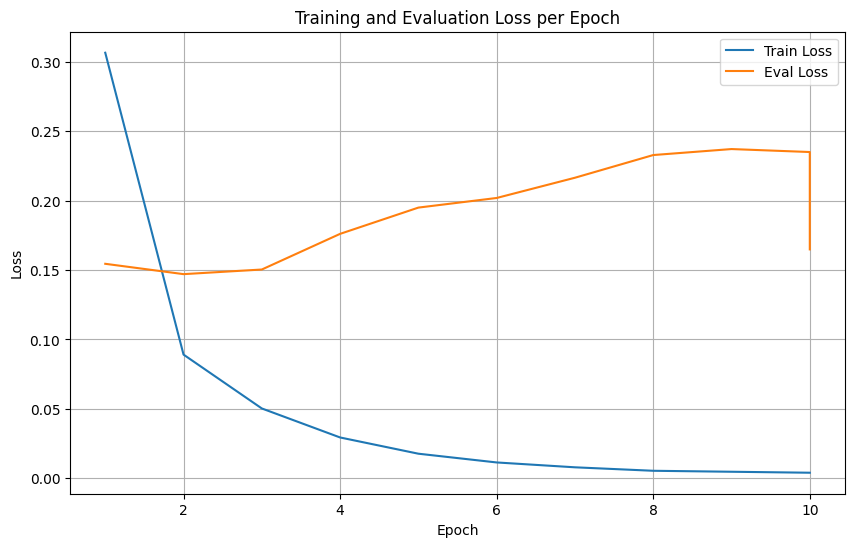

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the log history
log_df = pd.read_csv("training_log.csv")

# Optional: inspect columns
print(log_df.columns)

# Filter out rows with 'epoch' and specific metrics
train_loss = log_df[log_df["loss"].notna()]
eval_metrics = log_df[log_df["eval_loss"].notna()]

# Plot training and eval loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_loss["epoch"], train_loss["loss"], label="Train Loss")
plt.plot(eval_metrics["epoch"], eval_metrics["eval_loss"], label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

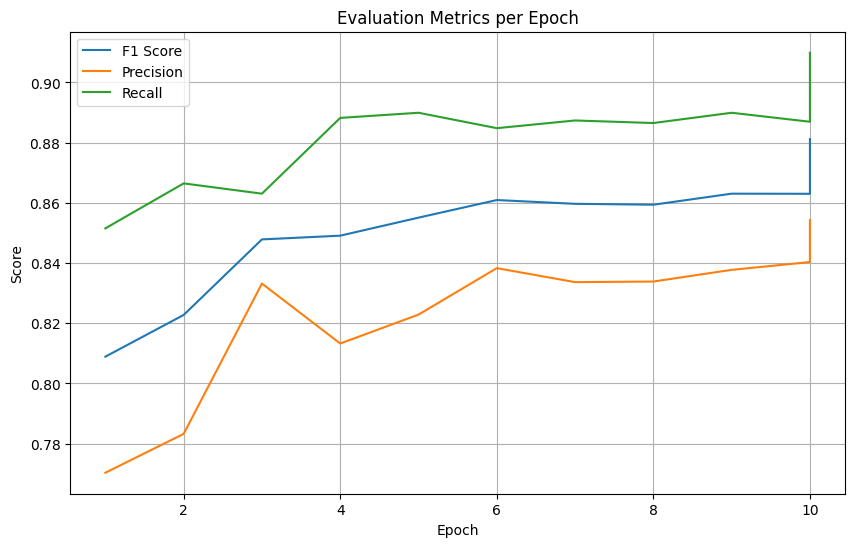

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(eval_metrics["epoch"], eval_metrics["eval_f1"], label="F1 Score")
plt.plot(eval_metrics["epoch"], eval_metrics["eval_precision"], label="Precision")
plt.plot(eval_metrics["epoch"], eval_metrics["eval_recall"], label="Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics per Epoch")
plt.legend()
plt.grid(True)
plt.show()
